In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sympy import * 
#from spring_damp import force_time, mass_damp_spring, ideal_actual, graphs
from spring_damp import mass_damp_spring, ideal_actual
import random
import yaml 
random.seed(63)

ai = ideal_actual(time = 90, increment = 0.01, state = [0,0], force = sin, amplitude= 1,\
    omega = 0.1, no_mass = 5, range_mass= [10, 20], no_spring= 20, range_spring = [1,10], no_damp = 20, range_damp = [0.1, 1], \
    delta_mass = 0, delta_spring = 0, delta_damp = 0) 


Text(0.5, 1.0, 'Force')

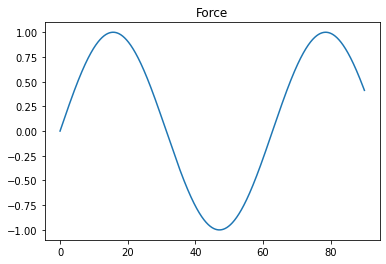

In [2]:
plt.plot(ai.time_array, ai.force_list)
plt.title("Force") 

Text(0.5, 1.0, 'mass')

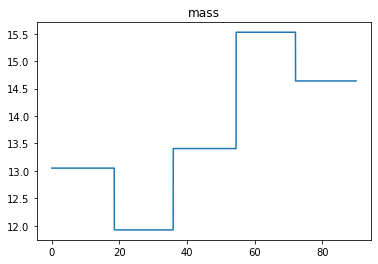

In [3]:
plt.plot(ai.time_array, ai.mass) 
plt.title("mass")

Text(0.5, 1.0, 'spring')

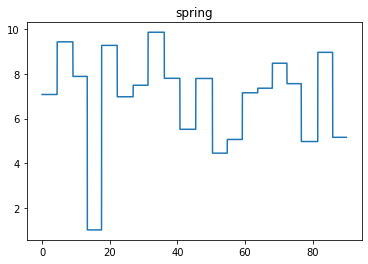

In [4]:
plt.plot(ai.time_array, ai.spring) 
plt.title("spring")  

Text(0.5, 1.0, 'Damp')

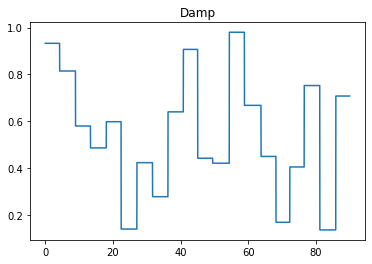

In [5]:
plt.plot(ai.time_array, ai.damp) 
plt.title("Damp")  

In [6]:
ideal_values = ai.ideal_values_list
ideal_acc = ai.ideal_acc 
from scipy.integrate import odeint 
def actual_diff(state, t):
    dx1dt = state[1]
    T = int(t * ai.product)
    m = (ai.mass[T])
    f = ai.force_list[T] 
    b = ai.damp[T] * state[1] 
    k = ai.spring[T] * (state[0]**3)
    dx2dt = m * (f - b - k)
    dxdt = [dx1dt, dx2dt]
    return dxdt 

actual_values = odeint(actual_diff, ai.state, ai.time_array, mxstep=50000000) 

def error():
    z1 = list(actual_values[:,0]) #actual_disp
    z2 = list(ideal_values[:,0]) #ideal_disp
    error = []
    for i in range(len(ai.time_array)):
        e =  (-1)* (ai.spring[i]/ai.mass[i]) * ( z1[i] - z2[i])  
        error.append(e) 
    return error

E = error() 

Text(0.5, 1.0, 'Error')

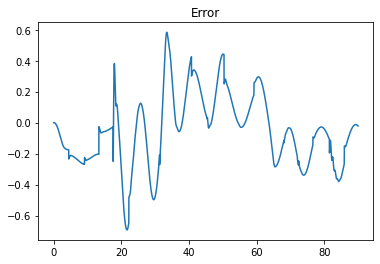

In [7]:
plt.plot(ai.time_array, E) 
plt.title("Error") 

In [8]:
#imp_colums = ["time_step", "force", "mass", "K", "B","actual_disp", "actual_vel", "G(x)"]

d = {
    "time" : ai.time_array,
    "force" : ai.force_list,
    "mass" : ai.mass,
    "K" : ai.spring,
    "B" : ai.damp,
    "actual_disp" : list(actual_values[:,0]),
    "actual_vel" : list(actual_values[:,1]),
    "G(x)" : E
    }
df = pd.DataFrame(d) 
df

,time,force,mass,K,B,actual_disp,actual_vel,G(x)
0,0.00,0.000000,13.051039,7.080762,0.932691,0.000000e+00,0.000000e+00,-0.000000e+00
1,0.01,0.001000,13.051039,7.080762,0.932691,3.094663e-14,7.261429e-09,1.695299e-11
2,0.02,0.002000,13.051039,7.080762,0.932691,6.265988e-07,1.228922e-04,-3.374241e-07
3,0.03,0.003000,13.051039,7.080762,0.932691,3.037665e-06,3.545668e-04,-1.636475e-06
4,0.04,0.004000,13.051039,7.080762,0.932691,8.256406e-06,6.825393e-04,-4.448450e-06
...,...,...,...,...,...,...,...,...
8996,89.96,0.415760,14.639285,5.157977,0.708225,4.392933e-01,-2.923010e-02,-2.076415e-02
8997,89.97,0.414850,14.639285,5.157977,0.708225,4.390007e-01,-2.927991e-02,-2.100672e-02
8998,89.98,0.413940,14.639285,5.157977,0.708225,4.387075e-01,-2.932985e-02,-2.125265e-02
8999,89.99,0.413029,14.639285,5.157977,0.708225,4.384139e-01,-2.937992e-02,-2.150194e-02


In [9]:
from sklearn.preprocessing import StandardScaler 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel, RationalQuadratic

ss = StandardScaler()

k = 9000//100 * (90) 
X_train = df.iloc[:k, :7]
y_train = df.iloc[:k, 7:]
X_test = df.iloc[k+1:, :7]
y_test = df.iloc[k+1:, 7:] 

x_tr = ss.fit_transform(X_train)
x_te = ss.fit_transform(X_test) 
y_tr = ss.fit_transform(y_train)
y_te = ss.fit_transform(y_test) 

rbf = ConstantKernel(1.0, (1e-1, 1e3) ) * RBF(10, (1e-7, 1e7))
white = WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 0.5**2))
k = rbf + white

rq =  ConstantKernel(1.0, (1e-1, 1e3) ) * RationalQuadratic(length_scale=1.0, alpha=2)

gpr = GaussianProcessRegressor(kernel=rq, alpha=0.1) 

gpr.fit(x_tr, y_tr)

GaussianProcessRegressor(alpha=0.1,
                         kernel=1**2 * RationalQuadratic(alpha=2, length_scale=1))

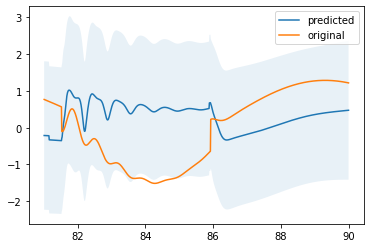

In [10]:
params = gpr.kernel_.get_params() 
mu_s, cov_s = gpr.predict(x_te, return_cov=True) 
mu_s = mu_s.ravel()

std = 1.96 * np.sqrt(np.diag(cov_s))
plt.plot(X_test['time'], mu_s)
plt.plot(X_test['time'], y_te)
plt.fill_between(X_test['time'], mu_s + std, mu_s - std, alpha = 0.1)
plt.legend(["predicted", "original"]) 

In [11]:
params = gpr.kernel_.get_params() 
mu_s, cov_s = gpr.predict(x_tr, return_cov=True) 
mu_s = mu_s.ravel()

std = 1.96 * np.sqrt(np.diag(cov_s))
plt.plot(X_train['time'], mu_s)
plt.plot(X_train['time'], y_tr)
plt.fill_between(X_train['time'], mu_s + std, mu_s - std, alpha = 0.1)
plt.legend(["predicted", "original"]) 

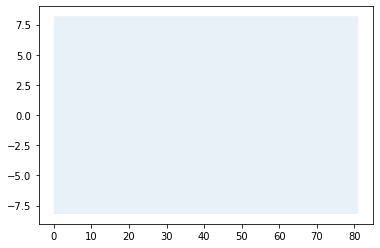

In [ ]:
plt.fill_between(X_train['time'], mu_s + std, mu_s - std, alpha = 0.1) 